# Bird-Building Collisions - An Evaluation using GridDB 

## The Alarming Upsurge of Bird-Building Collisions

Skyscrapers and tall towers look splendid and can uplift the look of any city. Big buildings and bright lights are great to look at, and perfectly safe for human beings. But are they safe for birds? Apparently not. According to the Audubon Mid-Atlantic, atleast 365 million birds collide with buildings every year in the United States. The numbers can go upto 1 billion in some cases. Scientists warn that while bird-building collisions can result in an increased mortality of birds, they also lead to the decline and subsequent extinction of many bird species. In this article, we use GridDB and Python to derive insights into this often-overlooked threat. 

In [318]:
import os
import pandas as pd
import numpy as np
import requests  # to make http calls
import http
http.client.HTTPConnection.debuglevel = 1
from datetime import date
from datetime import datetime
import json # to parse different data objects like string, etc. to JSON
import tabulate
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

## The Dataset

The dataset used for this analysis can be downloaded from <a href = "https://data.world/animals/bird-building-collisions"> data.world </a> or from the official website of <a href = "https://datadryad.org/stash/dataset/doi:10.5061/dryad.8rr0498"> DRYAD </a> The Dataset contains collisions recorded in Chicago and Cleveland along with the associated light levels. Please not that this data is limited to Chicago and Cleveland and hence are not representative of other states in the United States.

<b> Citation: </b> Winger, Benjamin M. et al. (2019), Nocturnal flight-calling behaviour predicts vulnerability to artificial light in migratory birds, Proceedings of the Royal Society B: Biological Sciences, Article-journal, https://doi.org/10.1098/rspb.2019.0364

In [2]:
Chicago_Collisions = pd.read_csv("Chicago_collision_data.csv", sep =",")
Cleveland_Collisions = pd.read_csv("Cleveland_collision_data.csv", sep =",")
Light_levels = pd.read_csv("Light_levels_dryad.csv", sep =",")

For Collection containers, the rowkey can be of any type. However, for Timeseries containers, the <b> rowkey </b> should be of the <b> timestamp </b> format. Hence, we process the 'Date' field in the form of a timestamp.

In [3]:
Chicago_Collisions['Date'] = Chicago_Collisions['Date'] + " 12:00:00"
Cleveland_Collisions['Date'] = Cleveland_Collisions['Date'] + " 12:00:00"
Light_levels['Date'] = Light_levels['Date'] + " 12:00:00"

Chicago_Collisions['Date'] = pd.to_datetime(Chicago_Collisions['Date'])
Cleveland_Collisions['Date'] = pd.to_datetime(Cleveland_Collisions['Date'])
Light_levels['Date'] = pd.to_datetime(Light_levels['Date'])
Light_levels.Light_Score = Light_levels.Light_Score.astype(str)

### Changing the sequence of columns
The columns need to be re-ordered such that the 'Date' is the first column in the data. This is because time-series containers in GRIDDB expect a timestamp column to be the first key column.

In [4]:
chicago_cols = list(Chicago_Collisions.columns.values)
chicago_cols # ['Genus', 'Species', 'Date', 'Locality']
# Re-arrange to ['Date', 'Genus', 'Species', 'Locality']
Chicago_Collisions = Chicago_Collisions[['Date', 'Genus', 'Species', 'Locality']]

In [5]:
cleveland_cols = list(Cleveland_Collisions.columns.values)
cleveland_cols # ['Genus', 'Species', 'Date']
# Re-arrange to ['Date', 'Genus', 'Species']
Cleveland_Collisions = Cleveland_Collisions[['Date', 'Genus', 'Species']]

### Formatting Date as Timestamp
GRIDDB requires the key column for its timeseries to be of the format %Y-%m-%dT%H:%M:%SZ. As an example, the expected format is 2022-10-16T12:00:00Z.

In [6]:
Chicago_Collisions['Date'] = Chicago_Collisions['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.000Z"))

In [7]:
cleveland_cols = list(Cleveland_Collisions.columns.values)
cleveland_cols #['Genus', 'Species', 'Date']
# Re-arrange to ['Date','Genus','Species']
Cleveland_Collisions = Cleveland_Collisions[['Date', 'Genus', 'Species']]

In [8]:
Cleveland_Collisions['Date'] = Cleveland_Collisions['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.000Z"))

In [9]:
Light_levels['Date'] = Light_levels['Date'].apply(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S.000Z"))

## Constructing the Container - Setting up the Data Model

As you might know already, GridDB is highly scaleable NoSQL database that extends the typical Key-value store model to a key-container model. In addition, it supports two types of containers - a Collection and a Time Series Container. Refer to https://griddb.net/en/blog/data-modeling-with-griddb/ to learn more on how GridDB compares to other NoSQL databases like Riak, Cassandra and MongoDB and why GridDB is the best of the lot. This resource also clearly explains how each type of container needs to be created. The rowkey determines the type of container. In this case, our data model looks like the one below - 

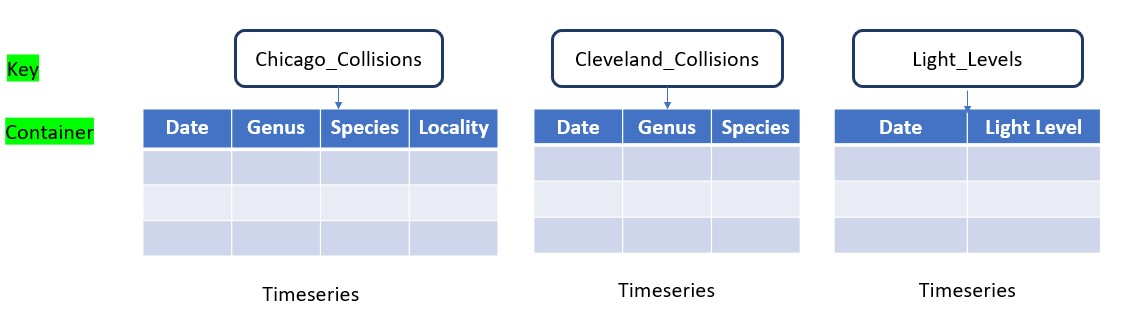

## Creating the Request (& Containers)

As per our requirements, we are required to create 3 containers. Note that while contructing a time series container, the container type should be 'TIME_SERIES' and the rowkey must be set to 'True'.

In [12]:
#Construct an object to hold the request headers (ensure that you replace the XXX placeholder with the correct value that matches the credentials for your GridDB instance)
header_obj = {"Authorization":"XXX","Content-Type":"application/json; charset=UTF-8","User-Agent":"PostmanRuntime/7.29.0"}

#Construct the base URL based on your GRIDDB cluster you'd like to connect to (ensure that you replace the placeholders in the URL below with the correct values that correspond to your GridDB instance)
base_url = 'https://[host]:[port]/griddb/v2/[clustername]/dbs/[database_name]'

In [122]:
#Creating the container 'Chicago_Collisions'
#Construct an object to hold the request body (i.e., the first container that needs to be created)
# Genus,Species,Date,Locality
data_obj_1 = {
    "container_name": "Chicago_Collisions",
    "container_type": "TIME_SERIES",
    "rowkey": True,
    "columns": [
    {
    "name": "Date",
    "type": "TIMESTAMP"
    },
    {
    "name": "Genus",
    "type": "STRING"
    },
    {
    "name": "Species",
    "type": "STRING"
    },
    {
    "name": "Locality",
    "type": "STRING"
    }
    ]
}

In [ ]:
#Set up the GridDB WebAPI URL
url = base_url+'containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj_1, headers = header_obj)

Here's a <b> TIP </b>: If you are new to GRIDDB and need help understanding the data types, check out this resource - <a href= "https://docs.griddb.net/tqlreference/type/#floating-point"> 'Data Types in GridDB' </a> It is important to note that the data types are case sensitive e.g. Timestamp should be specified in upper case and not in title case or lower case.

In [169]:
#Creating the container 'Cleveland_Collisions'
#Construct an object to hold the request body (i.e., the second container that needs to be created)
data_obj_2 = {
    "container_name": "Cleveland_Collisions",
    "container_type": "TIME_SERIES",
    "rowkey": True,
    "columns": [
    {
    "name": "Date",
    "type": "TIMESTAMP"
    },
    {
    "name": "Genus",
    "type": "STRING"
    },
    {
    "name": "Species",
    "type": "STRING"
    },    
    ]
}

In [ ]:
#Set up the GridDB WebAPI URL
url = base_url + 'containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj_2, headers = header_obj)

In [37]:
#Creating the container 'Light_levels'
#Construct an object to hold the request body (i.e., the third container that needs to be created)
data_obj_3 = {
    "container_name": "Light_levels",
    "container_type": "TIME_SERIES",
    "rowkey": True,
    "columns": [
    {
    "name": "Date",
    "type": "TIMESTAMP"
    },
    {
    "name": "Light_Score",
    "type": "STRING"
    },    
    ]
}

In [ ]:
#Set up the GridDB WebAPI URL
url = base_url + 'containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj_3, headers = header_obj)

## Data Loading - Populating the containers with data (Row Registration)

Now that all containers have been loaded, we load the data from the three dataframes into each of the containers. The process of loading data into a container is also known as <b> 'Row Registration' </b>. To read more about it, refer to the GRIDDB resource <a href = "http://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_3/GridDB_Web_API_Reference.html#%E3%83%AD%E3%82%A6%E7%99%BB%E9%8C%B2"> here</a>. 

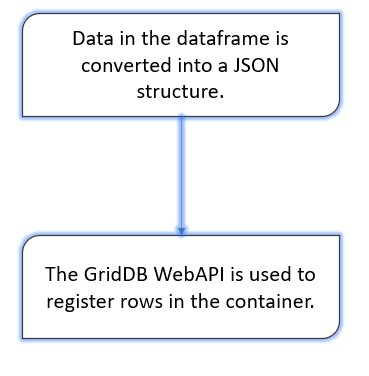
<center> Steps involved in Row Registration </center>

The 'to_json' function of the Pandas library is useful in constructing the JSON structure required for row registration.

### Populating data in the container 'Chicago_Collisions'

In [147]:
#Convert the data in the dataframe to the JSON format
Chicago_Collisions_json = Chicago_Collisions.to_json(orient='values')
request_body_chicago_collisions = Chicago_Collisions_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + '/containers/Chicago_Collisions/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_chicago_collisions, headers=header_obj)

In [166]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container Chicago_Collisions.')

69784 rows have been registered in the container Chicago_Collisions.


### Populating data in the container 'Cleveland_Collisions'

In [171]:
#Convert the data in the dataframe to the JSON format
Cleveland_Collisions_json = Cleveland_Collisions.to_json(orient='values')
request_body_cleveland_collisions = Cleveland_Collisions_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + '/containers/Cleveland_Collisions/rows'


#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_cleveland_collisions, headers=header_obj)

In [173]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container Cleveland_Collisions.')

2273 rows have been registered in the container Cleveland_Collisions.


### Populating data in the container 'Light_levels'

In [184]:
#Convert the data in the dataframe to the JSON format
Light_levels_json = Light_levels.to_json(orient='values')
request_body_Light_levels = Light_levels_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + '/containers/Light_levels/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_Light_levels, headers=header_obj)

In [190]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container Light_levels.')

3067 rows have been registered in the container Light_levels.


## Querying the database

We are now going to find insightful answers to questions about Bird-Building collisions using GridDB's powerful query database. The three containers that were created are going to be queried for actionable insights. 

### Harnessing the timeseries functions of GRIDDB

GRIDDB offers easy to use time-series functions that can be leveraged for quick insights. Read more <a href =" https://docs.griddb.net/architecture/database-function/#operation-function-of-tql"> here.</a> Here, we use some time-series functions along with the standard sql functions available in GRIDDB.

### What is the range of data available for Collisions in Chicago?  

In [67]:
#Construct the SQL to be used
sql_query1 = ("SELECT max(Date) as cnt FROM Chicago_Collisions")

In [68]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1+'"}]'

In [ ]:
#Invoke the GridDB WebAPI
query_req1 = requests.post(url, data=request_body, headers=header_obj)

In [70]:
query_req1.text

'[{"columns":[{"name":"cnt","type":"TIMESTAMP"}],"results":[["2016-11-30T12:00:00.000Z"]]}]'

There's data as recent as <b> 2016 </b>.

In [62]:
#Construct the SQL to be used
sql_query2 = ("SELECT min(Date) as cnt FROM Chicago_Collisions")

In [63]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query2+'"}]'

In [ ]:
#Invoke the GridDB WebAPI
query_req2 = requests.post(url, data=request_body, headers=header_obj)

In [65]:
query_req2.text

'[{"columns":[{"name":"cnt","type":"TIMESTAMP"}],"results":[["1978-09-15T12:00:00.000Z"]]}]'

The 'Chicago Collisions' dataset has data from <b> 1978 to 2016 </b>.

### When did a collision take place in Chicago on or after the New Year 2016 (1st of Jan 2016)?

The start of every Year is indeed a happy occasion for all of us; but not for all living beings. Let's see if there was a bird that was killed on or after New Year's day.  

For this, we use the TIME_NEXT function of TQL. When this statement is used, GRIDDB selects a row whose timestamp is identical with or just after the specified timestamp. Read more about it <a href = "https://docs.griddb.net/tqlreference/tql-syntax-and-calculation-functions/#aggregation-operations-time-series"> here. </a> 

In this case, it fetches the specific bird-building collision that happened after 2016-01-01.

In [271]:
#Construct the TQL to be used
tql_query1 = "SELECT TIME_NEXT(*, TIMESTAMP('2016-01-01T00:00:00Z')) "

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'tql'

#Construct the request body which has the SQL that is to be used to retrieve the data
request_body = '[{"name":"Chicago_Collisions", "stmt":"'+tql_query1+'","columns":[]}]' 

#Invoke the GridDB WebAPI
query_req3 = requests.post(url, data=request_body, headers=header_obj)

In [274]:
query_req3.text

'[{"columns":[{"name":"Date","type":"TIMESTAMP"},{"name":"Genus","type":"STRING"},{"name":"Species","type":"STRING"},{"name":"Locality","type":"STRING"}],"results":[["2016-03-07T12:00:00.000Z","Melospiza","melodia","MP"]],"offset":0,"limit":10000,"total":-1}]'

<b>Insight: </b>
As per the <b> TIME_NEXT </b> function, the very next time a collision has been recorded after 2016-01-01 is <b> 2016-03-07</b>. A bird of the Melospiza genus and Melodia species was killed in McCormick Place, Chicago. In other words, a <b> song sparrow </b> was killed in a bird-building collision as of 01-01-2016.

<div>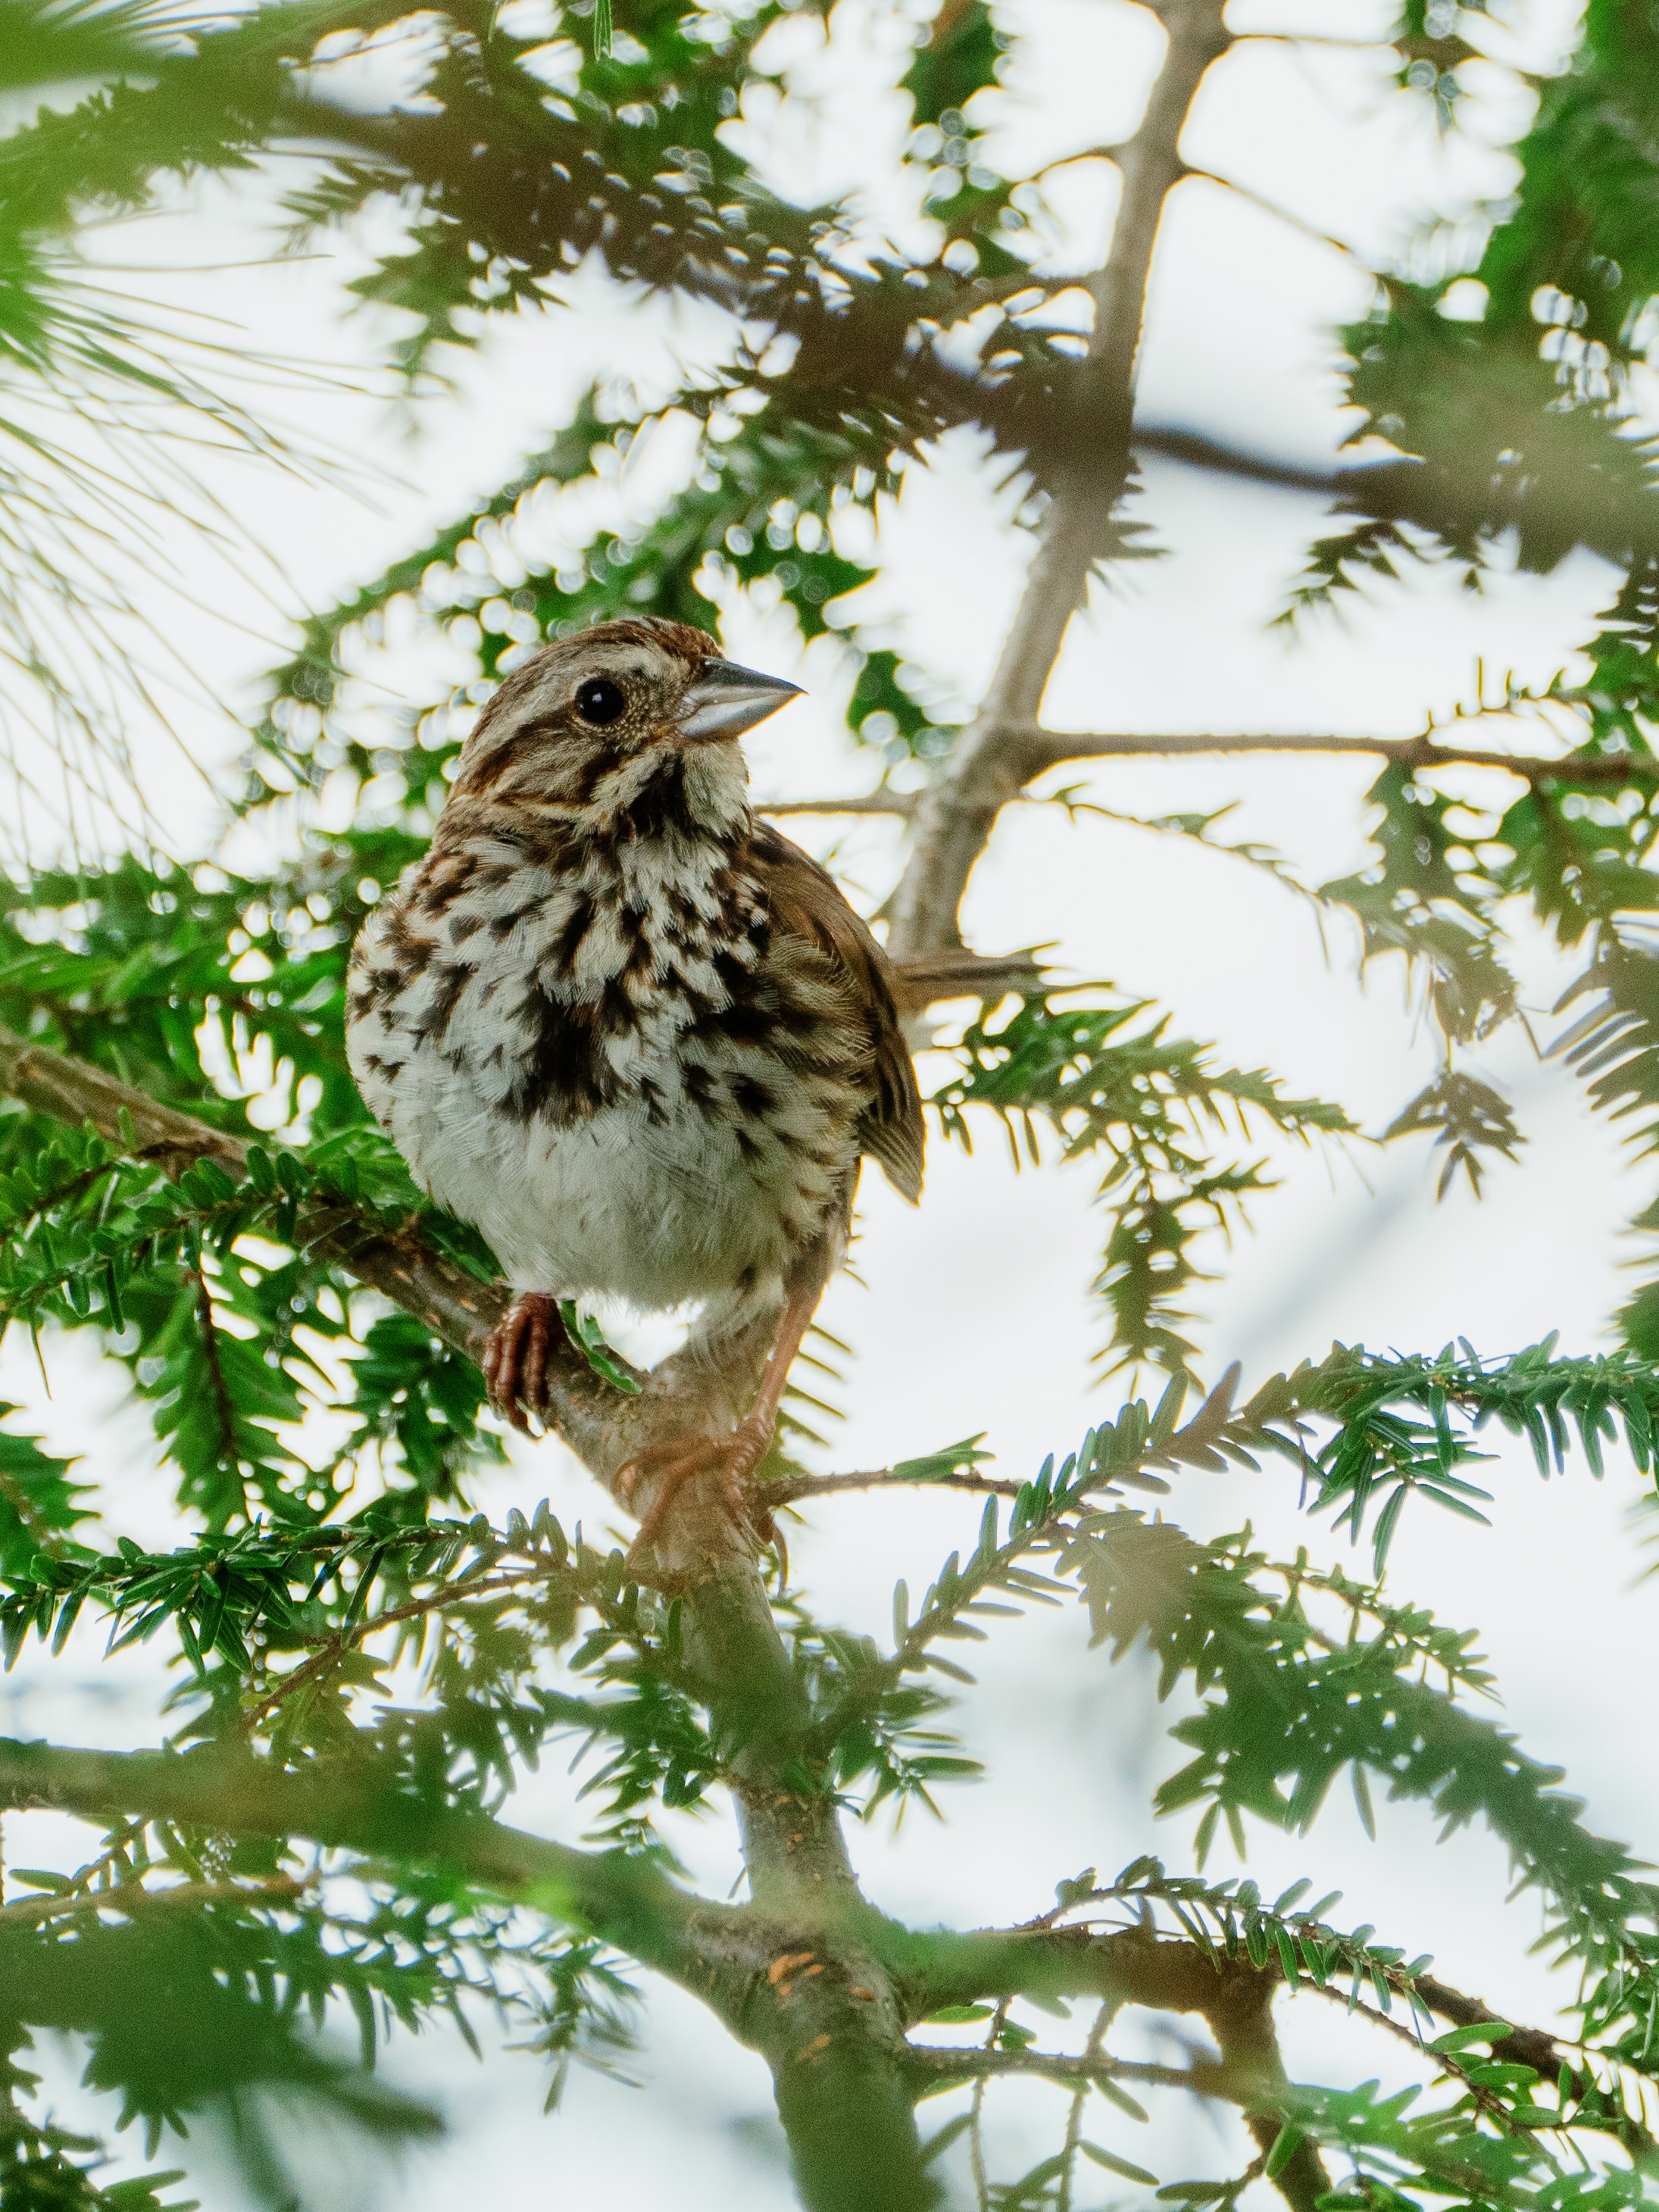</div> 
<center> Melospiza Melodia/Song Sparrow </center>
<center> Image Courtesy: <a href= "https://unsplash.com/@markolsen"> Mark Olsen </a> on Unsplash </center>

### When did a collision take place in Chicago before the 4th of July 2016?

The TIME_PREV function fetches the record that lies just before the specified timestamp, in this case, 2016-07-03. 

In [265]:
#Construct the TQL to be used
tql_query2 = "SELECT TIME_PREV(*, TIMESTAMP('2016-07-04T00:00:00Z')) "

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + 'tql'

#Construct the request body which has the SQL that is to be used to retrieve the data
request_body = '[{"name":"Chicago_Collisions", "stmt":"'+tql_query2+'","columns":[]}]' 

#Invoke the GridDB WebAPI
query_req4 = requests.post(url, data=request_body, headers=header_obj)

In [276]:
query_req4.text

'[{"columns":[{"name":"Date","type":"TIMESTAMP"},{"name":"Genus","type":"STRING"},{"name":"Species","type":"STRING"},{"name":"Locality","type":"STRING"}],"results":[["2016-05-30T12:00:00.000Z","Dumetella","carolinensis","MP"]],"offset":0,"limit":10000,"total":-1}]'

A bird of the genus 'Dumetella' and species 'Carolinensis' was killed in a collision as of 2016-05-30. This bird that died was a <b> Gray Catbird </b>.

<div>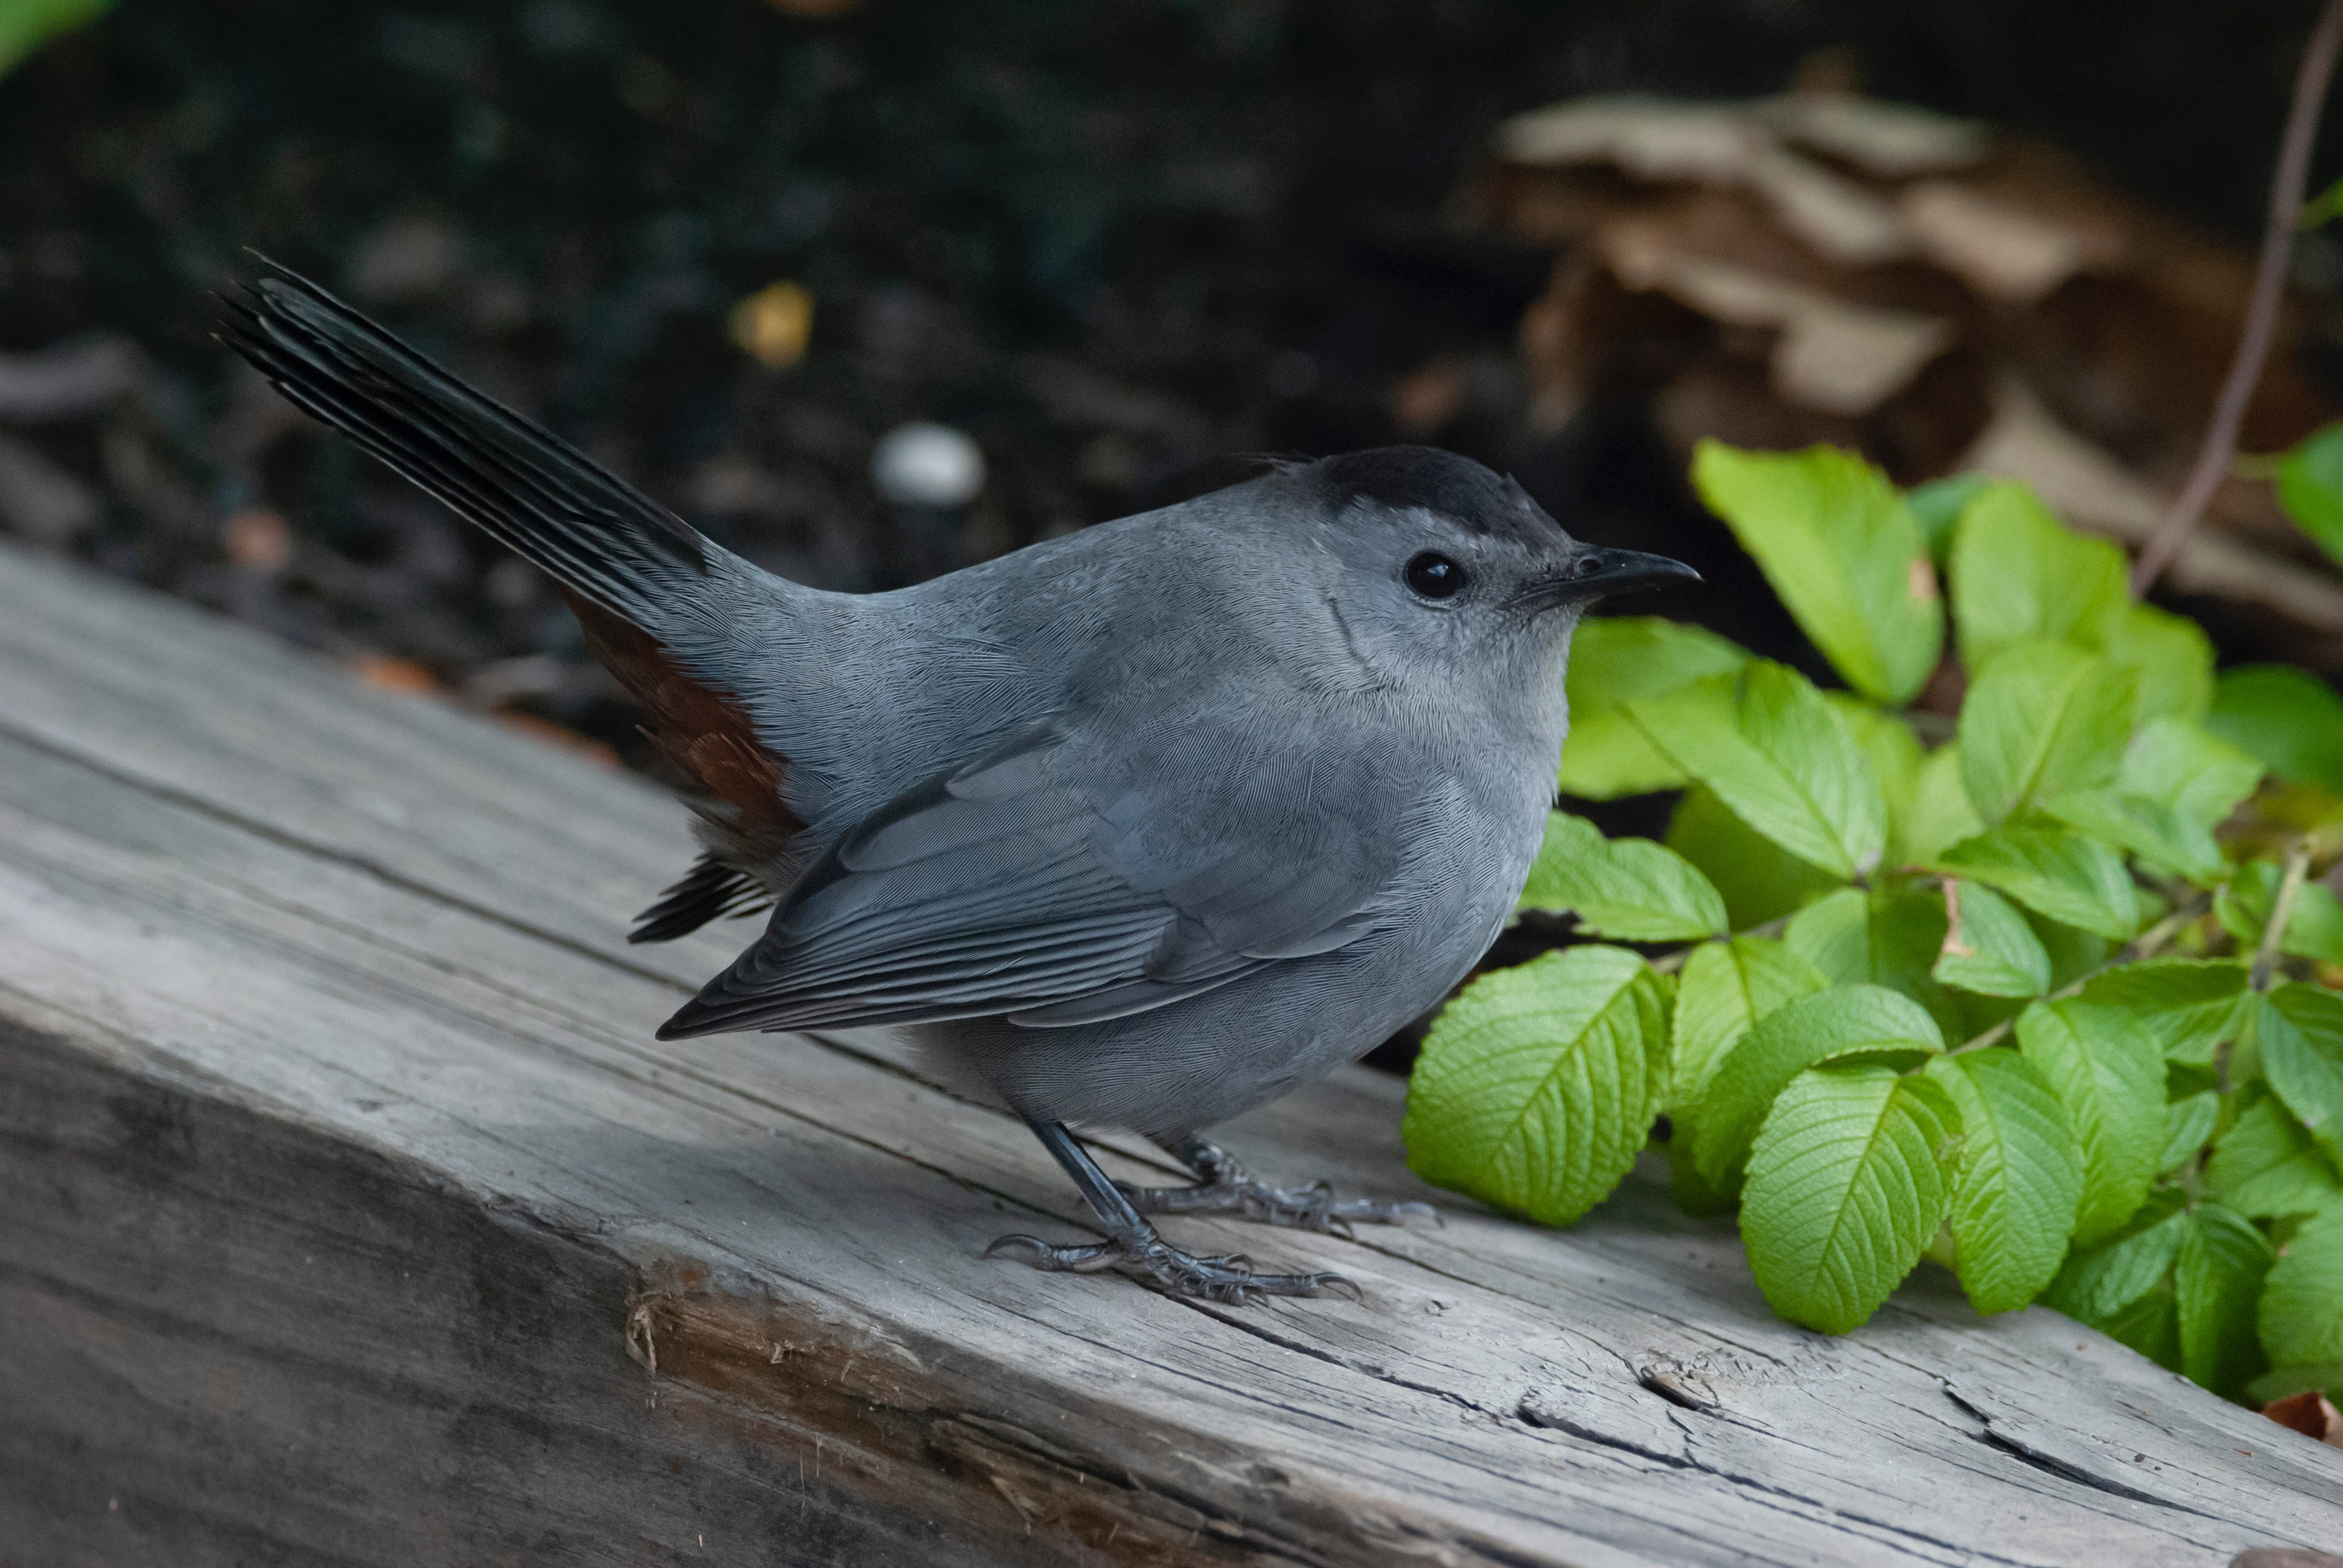</div> 
<center> Dumetella Carolinensis/Gray Catbird </center>
<center> Image Courtesy: <a href = "https://unsplash.com/@moultoty">Tyler Moulton</a> on Unsplash.

## How many birds were killed from 1978 to 2016 in Chicago?

In addition to TQL, GRIDDB also offers all standard SQL functions like Aggregation and Time functions. Read more about it <a href = "https://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_5/GridDB_SQL_Reference.html#extract"> GRIDDB's official SQL Reference. </a> 

In [13]:
#Construct the SQL to be used
sql_query1 = ("SELECT genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as cnt FROM Chicago_Collisions group by 1,2,3")

In [14]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as cnt FROM Chicago_Collisions group by 1,2,3"}]'

Invoke the GridDB SQL API to retrieve the results and process it. 

In [ ]:
#Invoke the GridDB WebAPI
data_req1 = requests.post(url, data=request_body, headers=header_obj)

In [16]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req1.json()
Chicago_Collision_Incidents = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"]])
Chicago_Collision_Incidents=Chicago_Collision_Incidents.sort_values(by=['cnt'], ascending=False)

In [26]:
print(Chicago_Collision_Incidents.to_markdown()) 

|     | Genus        | Species          |   Incident_Year |   cnt |
|----:|:-------------|:-----------------|----------------:|------:|
| 613 | Melospiza    | melodia          |            1996 |    58 |
| 100 | Melospiza    | melodia          |            1994 |    53 |
| 718 | Melospiza    | melodia          |            1985 |    41 |
|  30 | Melospiza    | melodia          |            1995 |    41 |
| 521 | Melospiza    | melodia          |            2000 |    40 |
| 961 | Melospiza    | melodia          |            1988 |    39 |
| 631 | Melospiza    | melodia          |            1990 |    37 |
| 338 | Melospiza    | melodia          |            1993 |    37 |
| 773 | Melospiza    | melodia          |            2007 |    37 |
| 555 | Melospiza    | melodia          |            1991 |    36 |
| 859 | Melospiza    | melodia          |            2006 |    35 |
| 214 | Melospiza    | melodia          |            1983 |    35 |
| 367 | Melospiza    | melodia          |       

<b>Insights:</b> As you can see in the data table above, we see that the <b> Melospiza Melodia (Song Sparrows) and Melospiza Lincolnii (Lincoln's Sparrows) </b> are the ones that get killed mostly. <br>
Atleast <b> 20 birds have been killed per year </b> in the early 70s. By 2000s, this number increased manifold, with around <b> 45-50 birds being killed per year </b> in building collisions. 

<div><img src="attachment:Lincoln's%20Sparrow.jpg" width="400"/></div> 
<center> Melospiza Lincolnii (Lincoln's Sparrows)</center>
<center> Image Courtesy: <a href= "https://unsplash.com/@tim_k_01"> Timothy Kindrachuk </a> on Unsplash </center>
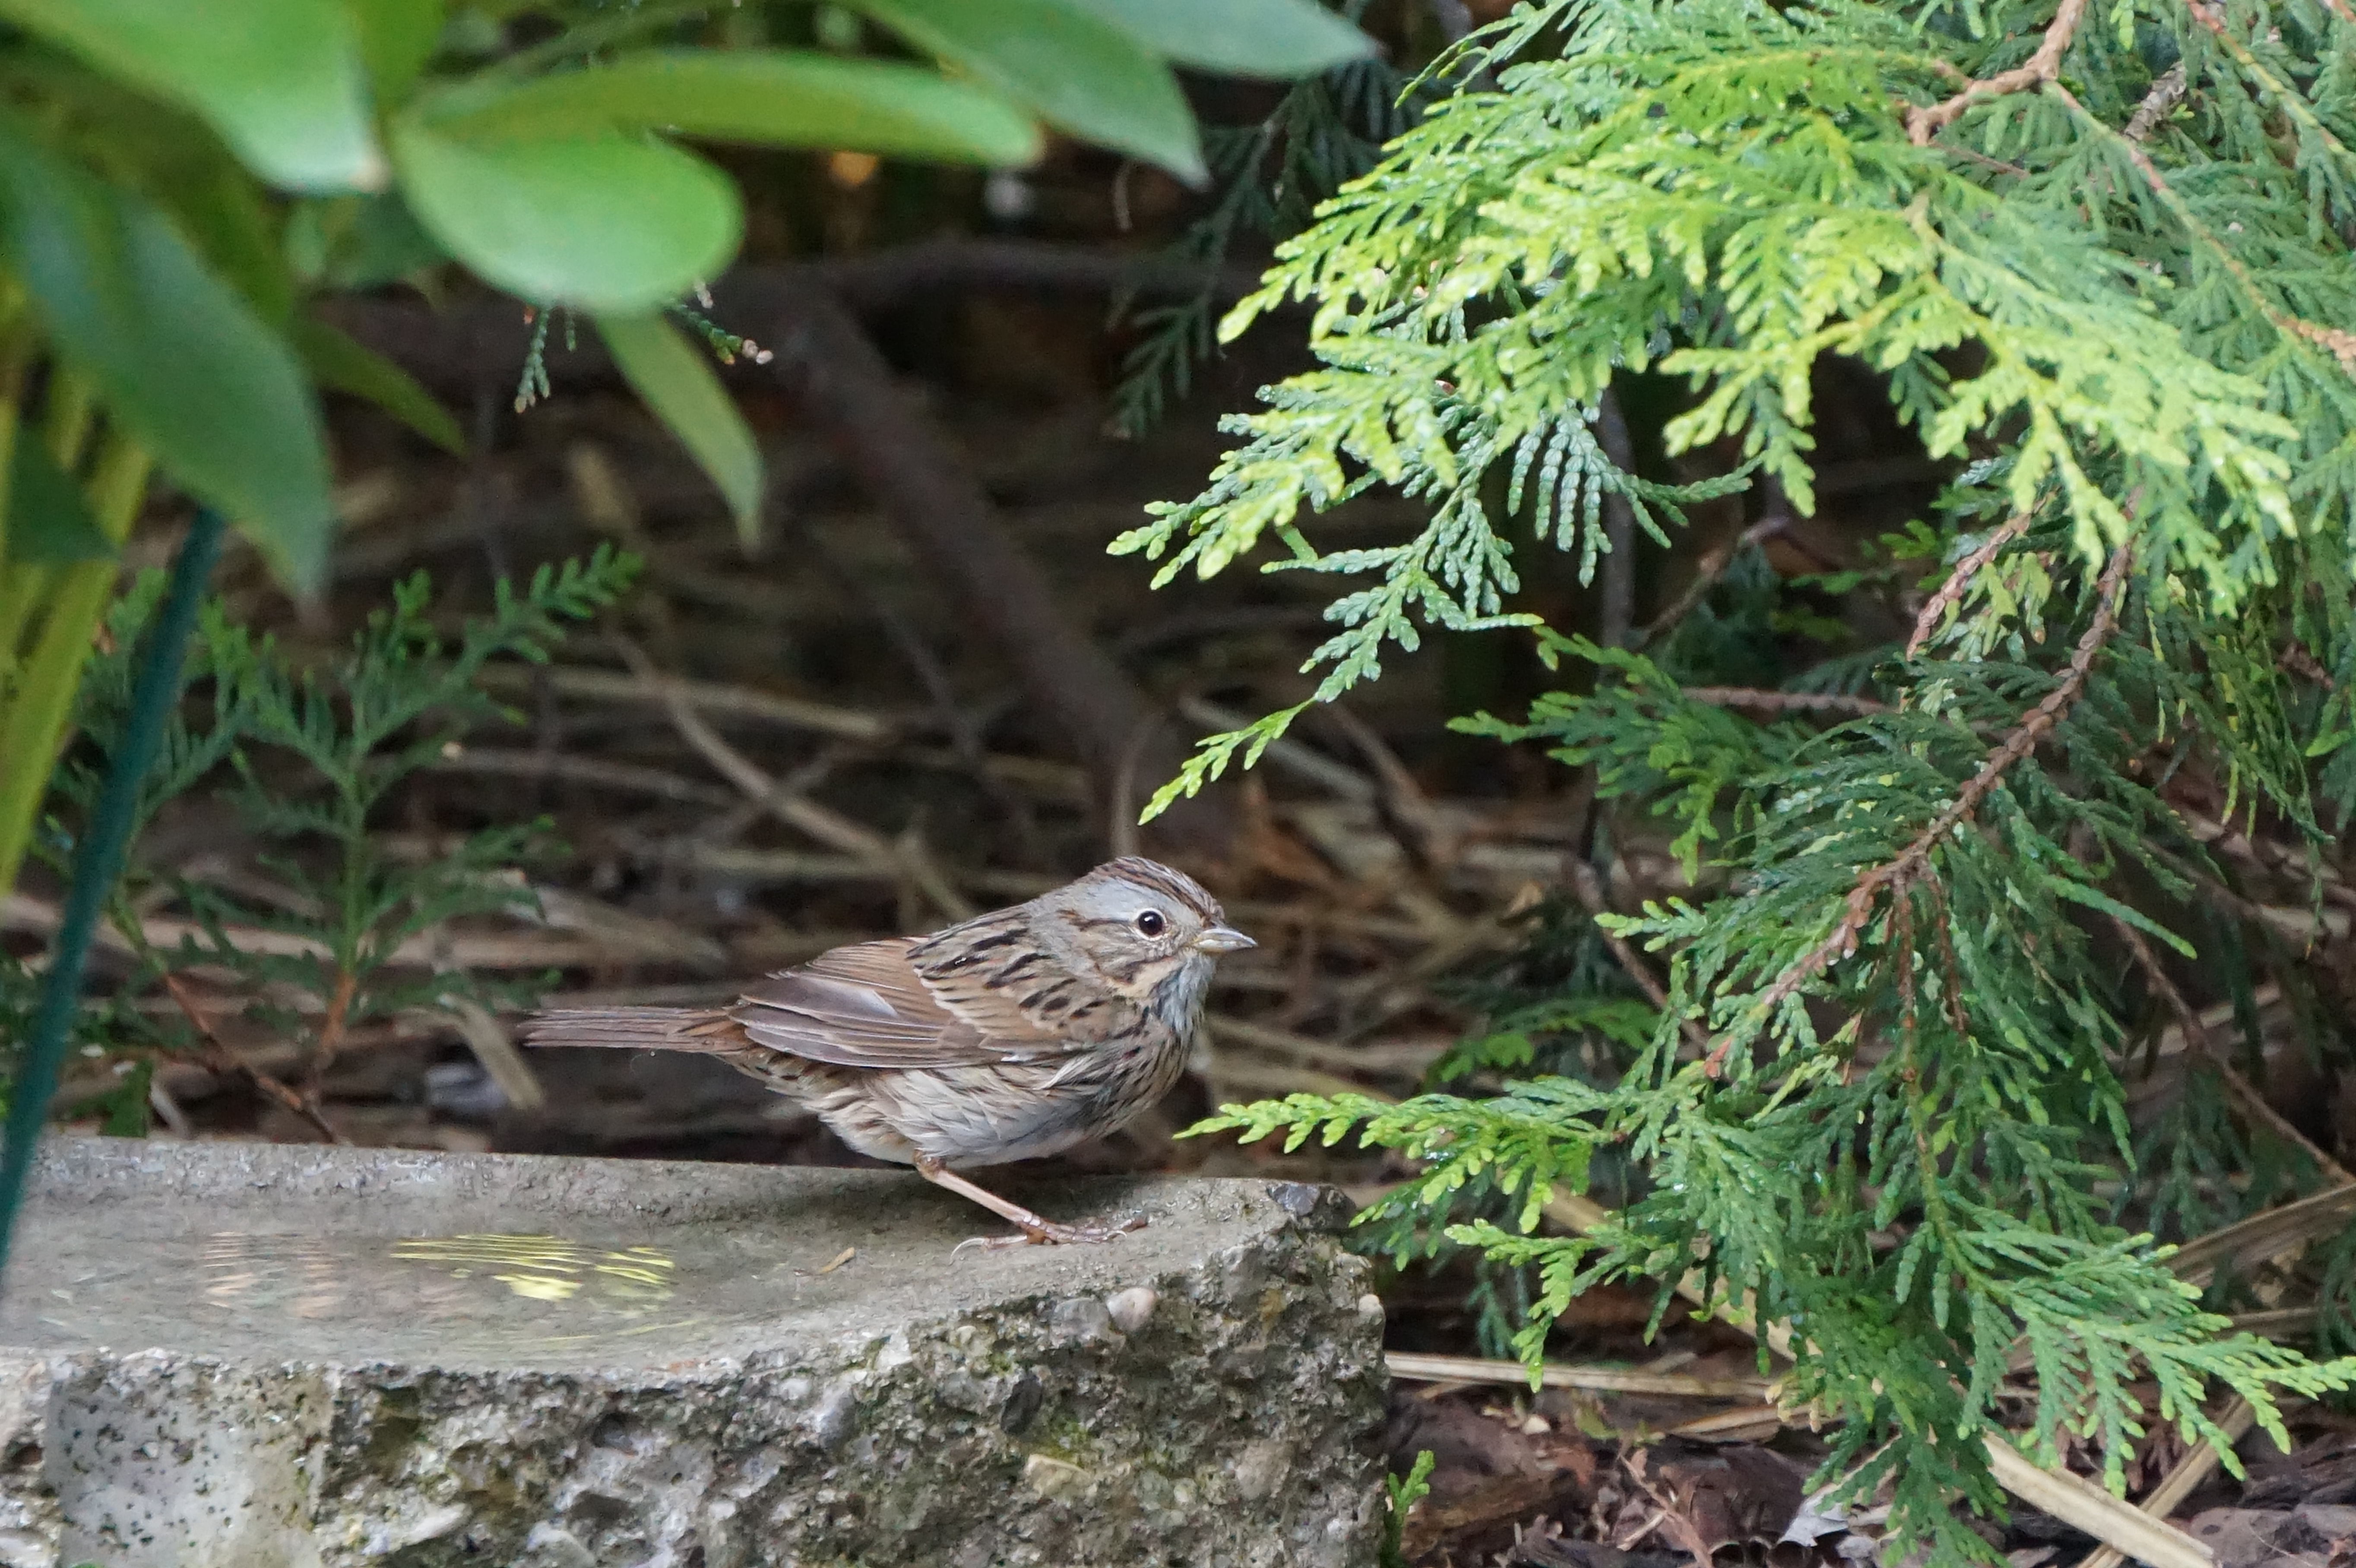

Let's add some subtotals to get more insights into the data.

In [27]:
def pivot_with_subtotals(df, values, indices, columns, aggfunc, fill_value):
    Table_list = []
    for i in range(len(indices)):
        n = i+1
        table = pd.pivot_table(df,values=values,index=indices[:n],columns=columns,aggfunc=aggfunc,fill_value=fill_value,sort=True).reset_index()
        for column in indices[n:]:
            table[column] = 'SubTotal'       
        Table_list.append(table)
    FinalTable = pd.concat(Table_list).sort_index()
    FinalTable = FinalTable.set_index(keys=indices)
    return FinalTable.sort_index(axis=0,ascending=False) # ascending=True/False controls the placement of the subtotals

In [28]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):    
    display(pivot_with_subtotals(df=Chicago_Collision_Incidents,values='cnt',indices=['Genus','Species'],columns=[],aggfunc='sum',fill_value=''))


cnt
Genus        Species               
Zonotrichia  querula              2
             leucophrys         204
             albicollis         439
             SubTotal           645
Vireo        solitarius           2
             philadelphicus       2
             olivaceus           37
             SubTotal            41
Vermivora    cyanoptera           3
             chrysoptera          4
             SubTotal             7
Troglodytes  hiemalis            15
             aedon                9
             SubTotal            24
Toxostoma    rufum               13
             SubTotal            13
Sturnella    magna                3
             SubTotal             3
Spizelloides arborea            158
             SubTotal           158
Spizella     pusilla             24
             passerina            5
             pallida              5
             SubTotal            34
Sitta        canadensis           6
             SubTotal             6
Setophaga    virens               3
             tigrina              2
             striata             19
             ruticilla           54
             petechia             6
             pensylvanica         3
             palmarum             7
             magnolia            11
             fusca                1
             coronata             7
             castanea             9
             caerulescens         3
             americana            3
             SubTotal           128
Seiurus      aurocapilla        162
             SubTotal           162
Sayornis     phoebe               3
             SubTotal             3
Regulus      satrapa             32
             calendula           10
             SubTotal            42
Pooecetes    gramineus            1
             SubTotal             1
Piranga      rubra                2
             olivacea             4
             SubTotal             6
Pipilo       erythrophthalmus     5
             SubTotal             5
Pheucticus   ludovicianus        20
             SubTotal            20
Passerina    cyanea              40
             SubTotal            40
Passerella   iliaca             334
             SubTotal           334
Passerculus  sandwichensis        2
             SubTotal             2
Parkesia     noveboracensis      71
             motacilla            2
             SubTotal            73
Oreothlypis  ruficapilla        142
             peregrina          281
             celata               4
             SubTotal           427
Oporornis    agilis              10
             SubTotal            10
Myiarchus    crinitus             2
             SubTotal             2
Mniotilta    varia               10
             SubTotal            10
Melospiza    melodia           1154
             lincolnii          797
             georgiana          526
             SubTotal          2477
Junco        hyemalis           228
             SubTotal           228
Icterus      spurius              1
             galbula              5
             SubTotal             6
Hylocichla   mustelina           15
             SubTotal            15
Geothlypis   trichas             39
             philadelphia        42
             formosa              1
             SubTotal            82
Empidonax    traillii             6
             minimus              2
             SubTotal             8
Dumetella    carolinensis        10
             SubTotal            10
Cistothorus  platensis            1
             palustris            1
             SubTotal             2
Certhia      americana           41
             SubTotal            41
Catharus     ustulatus           35
             minimus              5
             guttatus            42
             fuscescens           9
             SubTotal            91
Cardellina   pusilla             75
             canadensis          85
             SubTotal           160
Ammodramus   nelsoni              1
             leconteii            1


<b> Insights:</b> As we know, sparrows i.e., birds belonging to the genus Melospiza have been killed the largest. Since 1978,we have lost 2477 sparrows to building collisions. Similarly, we see that there have been 645 birds belonging to the genus <b> Zonotrichia (American Sparrows) </b> were also killed. 

## How many birds were killed from 1978 to 2016 in Cleveland?

In [29]:
#Construct the SQL to be used
sql_query2 = ("SELECT genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as cnt FROM Cleveland_Collisions group by 1,2,3")

In [30]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query2+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as cnt FROM Cleveland_Collisions group by 1,2,3"}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req2 = requests.post(url, data=request_body, headers=header_obj)

In [32]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req2.json()
Cleveland_Collision_Incidents = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"]])
Cleveland_Collision_Incidents=Chicago_Collision_Incidents.sort_values(by=['cnt'], ascending=False)

In [58]:
def pivot_with_subtotals(df, values, indices, columns, aggfunc, fill_value):
    Table_list = []
    for i in range(len(indices)):
        n = i+1
        table = pd.pivot_table(df,values=values,index=indices[:n],columns=columns,aggfunc=aggfunc,fill_value=fill_value,sort=True).reset_index()
        for column in indices[n:]:
            table[column] = 'SubTotal'       
        Table_list.append(table)
    FinalTable = pd.concat(Table_list).sort_index()
    FinalTable = FinalTable.set_index(keys=indices)
    return FinalTable.sort_index(axis=0,ascending=False) # ascending=True/False controls the placement of the subtotals

In [59]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 5,
                       ):    
    display(pivot_with_subtotals(df=Cleveland_Collision_Incidents,values='cnt',indices=['Genus','Species'],columns=[],aggfunc='sum',fill_value=''))


cnt
Genus        Species               
Zonotrichia  querula              2
             leucophrys         204
             albicollis         439
             SubTotal           645
Vireo        solitarius           2
             philadelphicus       2
             olivaceus           37
             SubTotal            41
Vermivora    cyanoptera           3
             chrysoptera          4
             SubTotal             7
Troglodytes  hiemalis            15
             aedon                9
             SubTotal            24
Toxostoma    rufum               13
             SubTotal            13
Sturnella    magna                3
             SubTotal             3
Spizelloides arborea            158
             SubTotal           158
Spizella     pusilla             24
             passerina            5
             pallida              5
             SubTotal            34
Sitta        canadensis           6
             SubTotal             6
Setophaga    virens               3
             tigrina              2
             striata             19
             ruticilla           54
             petechia             6
             pensylvanica         3
             palmarum             7
             magnolia            11
             fusca                1
             coronata             7
             castanea             9
             caerulescens         3
             americana            3
             SubTotal           128
Seiurus      aurocapilla        162
             SubTotal           162
Sayornis     phoebe               3
             SubTotal             3
Regulus      satrapa             32
             calendula           10
             SubTotal            42
Pooecetes    gramineus            1
             SubTotal             1
Piranga      rubra                2
             olivacea             4
             SubTotal             6
Pipilo       erythrophthalmus     5
             SubTotal             5
Pheucticus   ludovicianus        20
             SubTotal            20
Passerina    cyanea              40
             SubTotal            40
Passerella   iliaca             334
             SubTotal           334
Passerculus  sandwichensis        2
             SubTotal             2
Parkesia     noveboracensis      71
             motacilla            2
             SubTotal            73
Oreothlypis  ruficapilla        142
             peregrina          281
             celata               4
             SubTotal           427
Oporornis    agilis              10
             SubTotal            10
Myiarchus    crinitus             2
             SubTotal             2
Mniotilta    varia               10
             SubTotal            10
Melospiza    melodia           1154
             lincolnii          797
             georgiana          526
             SubTotal          2477
Junco        hyemalis           228
             SubTotal           228
Icterus      spurius              1
             galbula              5
             SubTotal             6
Hylocichla   mustelina           15
             SubTotal            15
Geothlypis   trichas             39
             philadelphia        42
             formosa              1
             SubTotal            82
Empidonax    traillii             6
             minimus              2
             SubTotal             8
Dumetella    carolinensis        10
             SubTotal            10
Cistothorus  platensis            1
             palustris            1
             SubTotal             2
Certhia      americana           41
             SubTotal            41
Catharus     ustulatus           35
             minimus              5
             guttatus            42
             fuscescens           9
             SubTotal            91
Cardellina   pusilla             75
             canadensis          85
             SubTotal           160
Ammodramus   nelsoni              1
             leconteii            1


In Cleveland, <b> 2477 birds </b> belonging to the genus Melospiza followed by <b> 645 birds </b> belonging to the genus Zonotrichia were killed in collisions. A few other birds that were killed include those of the genus <b> Oreothlypis and Passerella. </b>

<div>
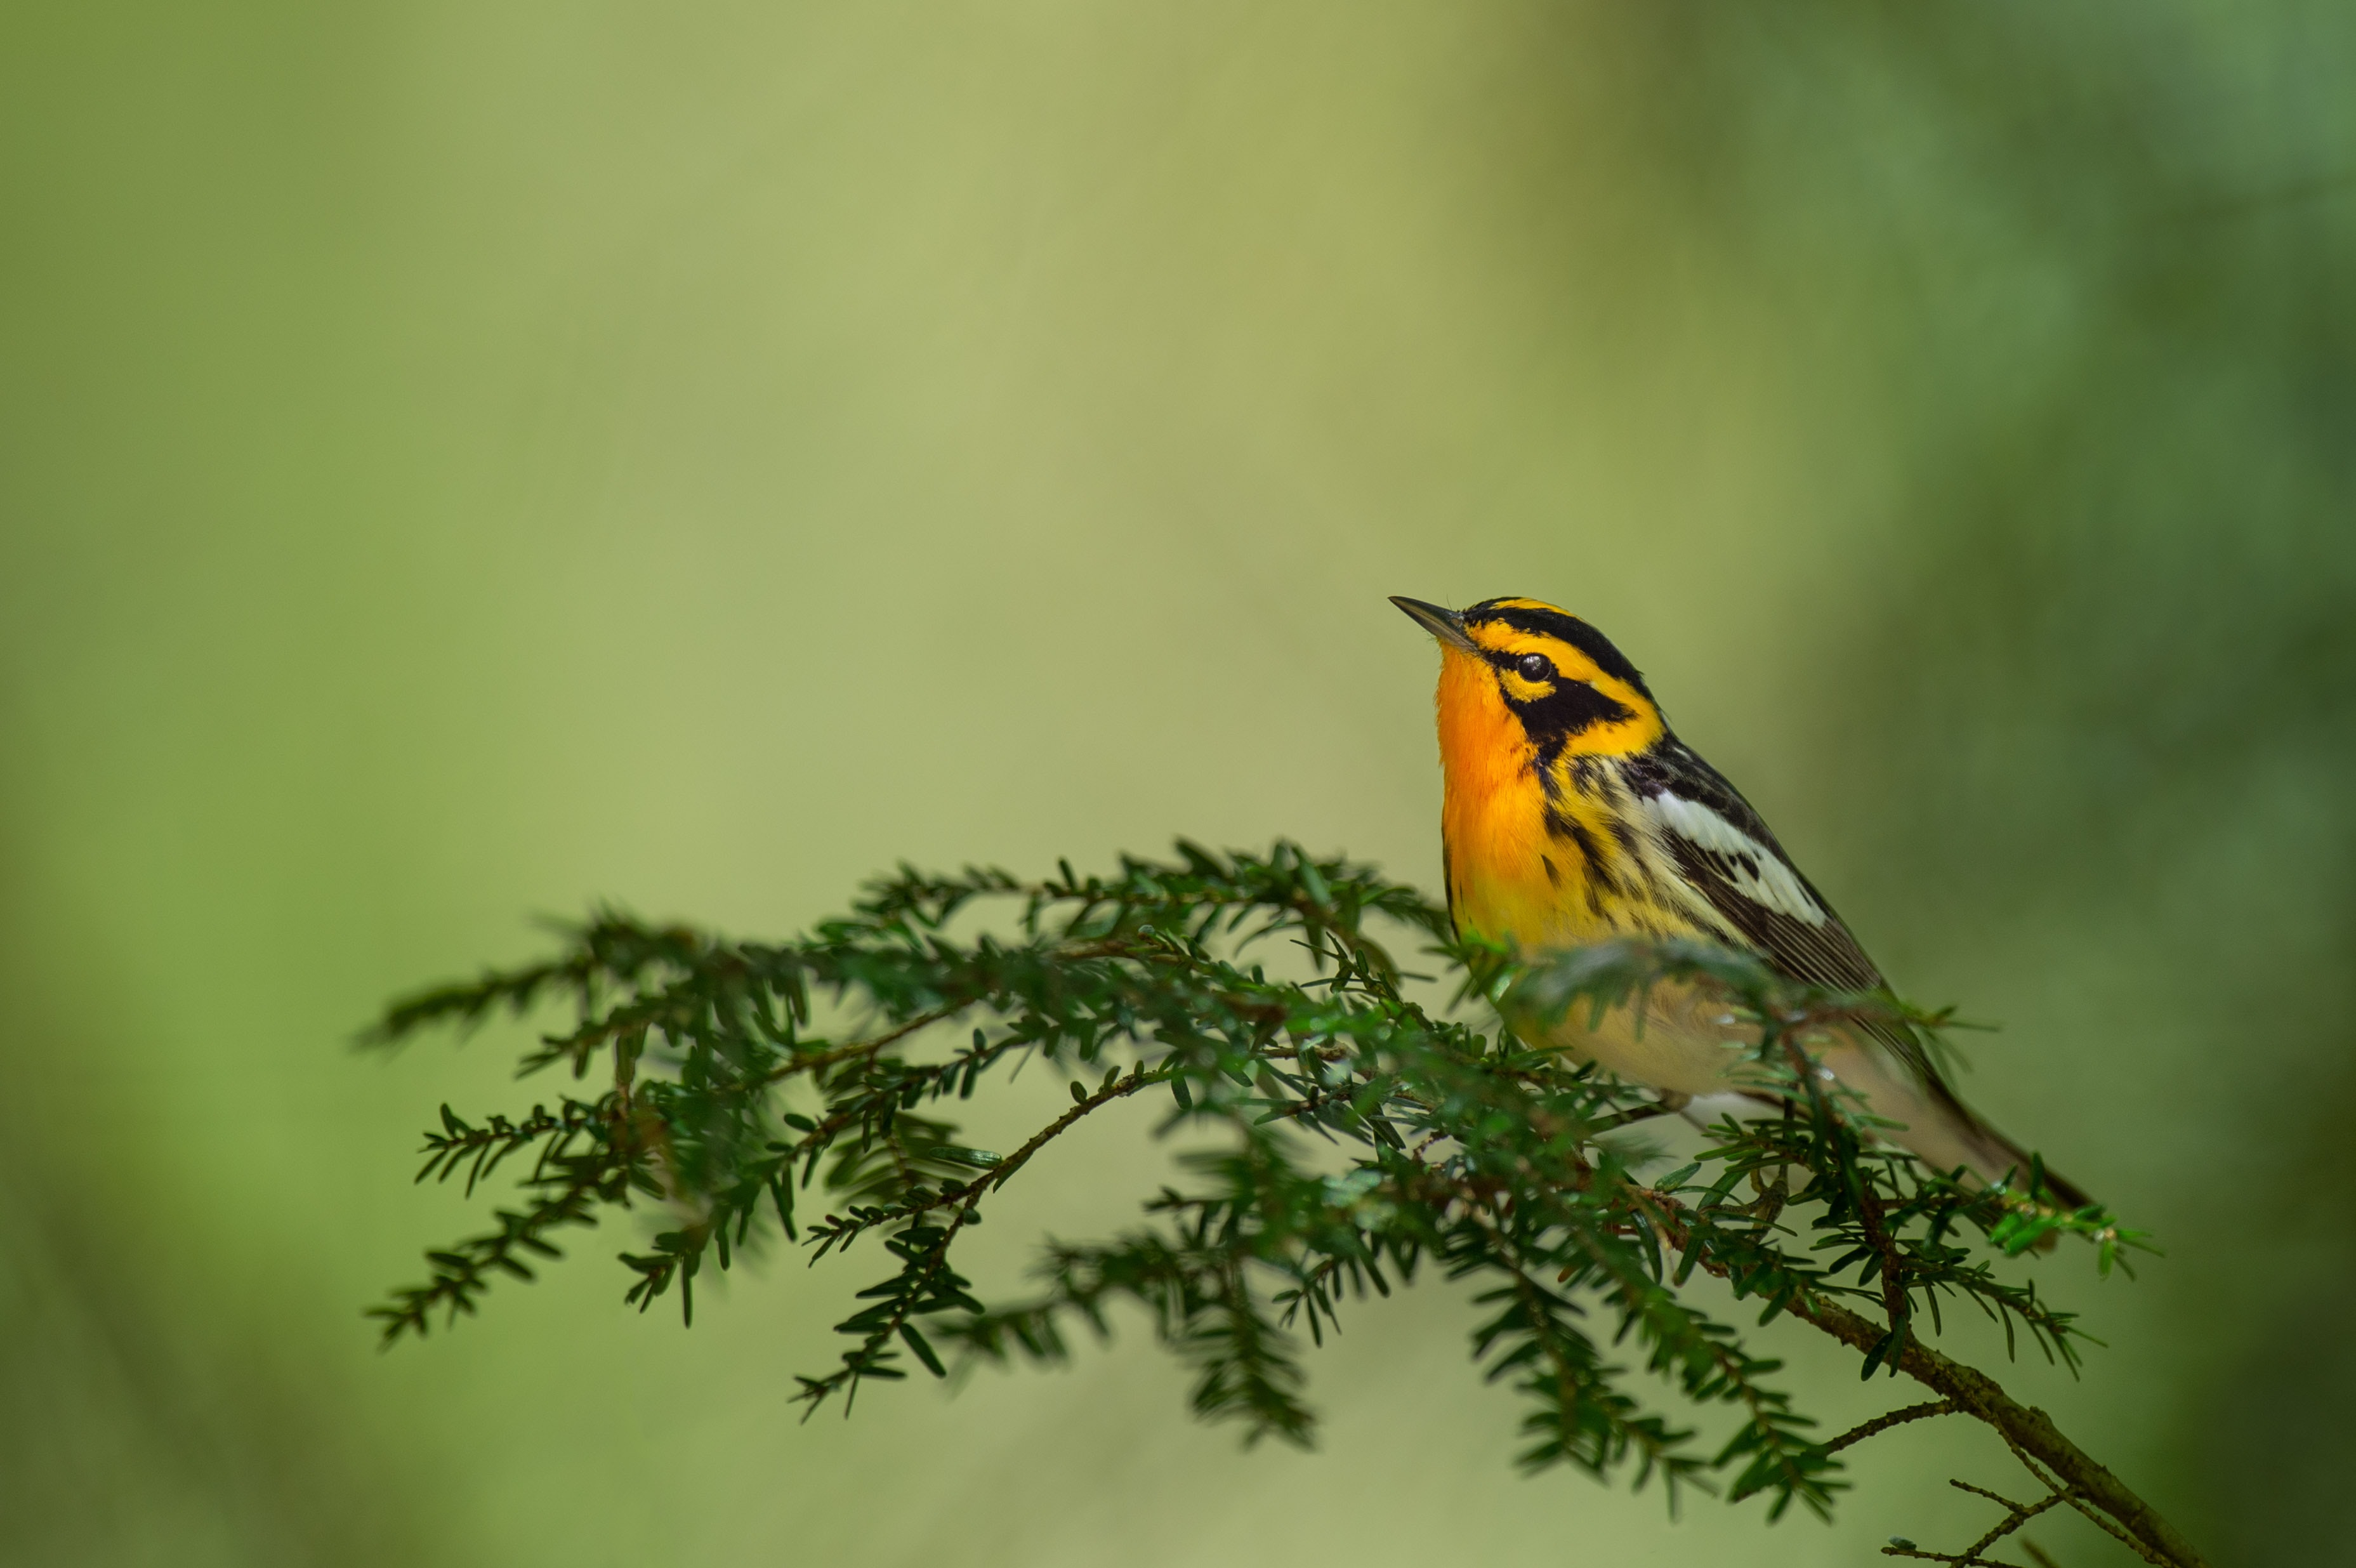
</div>
<center> Oreothlypis (Warbler) </center>
<center> Image Credit: <a href = "https://unsplash.com/@birdwatcher033342/collections"> Lydia Dexter </a> on Unsplash</center> 

# Exploring Joins and Subqueries in GRIDDB to answer deeper questions

In [137]:
sql_query3 = (f"""SELECT 'Chicago' as location, genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Chicago_Collisions group by 1,2,3,4 UNION ALL SELECT 'Cleveland' as location, genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Cleveland_Collisions group by 1,2,3,4 """)

In [138]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query3+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT \'Chicago\' as location, genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Chicago_Collisions group by 1,2,3,4 UNION ALL SELECT \'Cleveland\' as location, genus, species, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Cleveland_Collisions  group by 1,2,3,4 "}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req3 = requests.post(url, data=request_body, headers=header_obj)

## What does the trend of Collisions look like? (Across Chicago and Cleveland)

In [144]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req3.json()
All_Collision_Incidents = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"]])
All_Collision_Incidents=All_Collision_Incidents.sort_values(by=['Num'], ascending=False)

In [155]:
All_Collisions_grouped_by_Year = All_Collision_Incidents.groupby(['Incident_Year'])['Num'].sum().reset_index()

C:\Users\mg_su\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


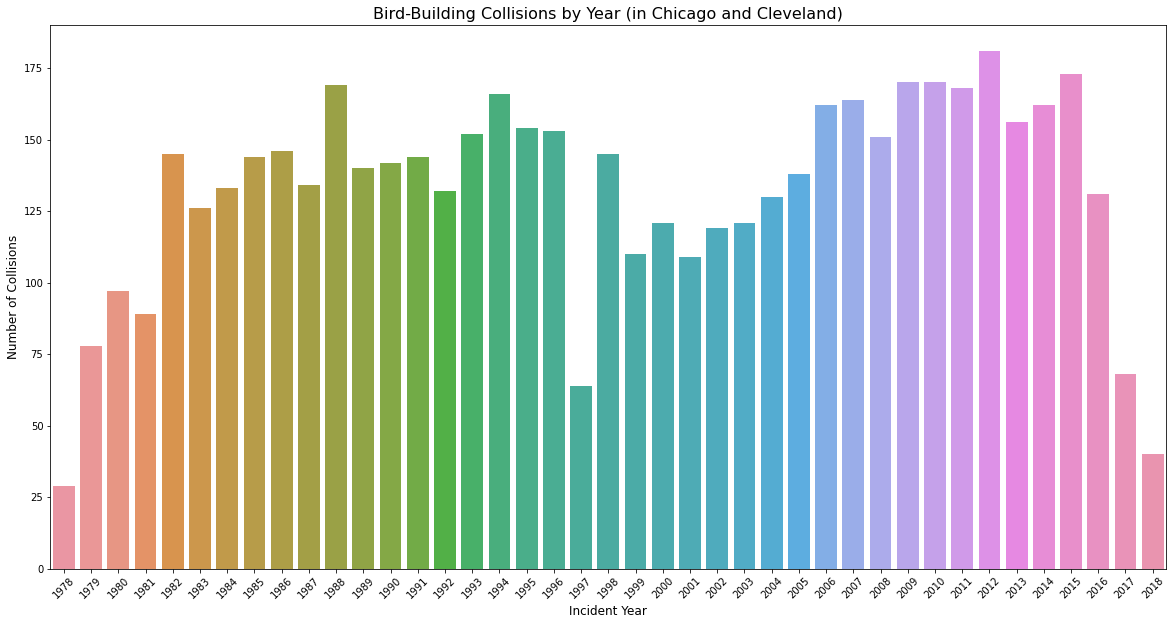

In [166]:
#Plot the data as a bar plot
fig,ax = plt.subplots(figsize=(20,10))
sns.barplot(All_Collisions_grouped_by_Year['Incident_Year'], All_Collisions_grouped_by_Year['Num'], ax=ax,order=All_Collisions_grouped_by_Year.Incident_Year)
ax.set_title('Bird-Building Collisions by Year (in Chicago and Cleveland)', fontsize = 16, loc='center')
ax.set_xlabel('Incident Year', fontsize = 12)
ax.set_ylabel('Number of Collisions', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

<b> Insight(s): </b> <li> There has been a dip in the collisions in the year 1997. Unfortunately, we do not have the data on the event that lead to the decrease in collisions.
<li> 1988 and 2012 have been the two years when collisions have been maximum (in the range of 160-175). 


## How many collisions take place on an average in Cleveland and Chicago?

In [167]:
sql_query4 = (f"""SELECT 'Chicago' as location, count(*)/count(distinct EXTRACT(YEAR, Date)) as Avg_Collisions FROM Chicago_Collisions group by 1 UNION ALL SELECT 'Cleveland' as location, count(*)/count(distinct EXTRACT(YEAR, Date)) as Avg_Collisions FROM Cleveland_Collisions group by 1""")

In [169]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query4+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT \'Chicago\' as location, count(*)/count(distinct EXTRACT(YEAR, Date)) as Avg_Collisions FROM Chicago_Collisions group by 1 UNION ALL SELECT \'Cleveland\' as location, count(*)/count(distinct EXTRACT(YEAR, Date)) as Avg_Collisions FROM Cleveland_Collisions group by 1"}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req4 = requests.post(url, data=request_body, headers=header_obj)

In [172]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req4.json()
Avg_Collisions = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"]])
Avg_Collisions=Avg_Collisions.sort_values(by=['Avg_Collisions'], ascending=False)

In [176]:
Avg_Collisions

location  Avg_Collisions
1    Chicago             136
0  Cleveland              54

<b>Insight(s):</b> In Chicago, there have been <b> 136 bird-building collisions per year on average </b> and in Cleveland, there have been <b> atleast 54 collisions per year on an average</b>. Chicago definitely has twice more collisions than Cleveland. 

# How have collisions varied by year and locality in Chicago?
The Chicago collisions dataset has the 'Locality' wherein the collisions were recorded. The Two Localities recorded include Mc Cormick Place and the rest of Chicago. To refer to the dataset usage notes, check this <a href = " https://datadryad.org/stash/dataset/doi:10.5061/dryad.8rr0498">resource.</a>

In [179]:
sql_query5 = (f"""SELECT Locality, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Chicago_Collisions group by 1,2""")

In [180]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query5+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT Locality, EXTRACT(YEAR, Date) as Incident_Year, count(*) as Num FROM Chicago_Collisions group by 1,2"}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req5 = requests.post(url, data=request_body, headers=header_obj)

In [188]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req5.json()
Chicago_Collisions_by_Locality = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])
Chicago_Collisions_by_Locality=Chicago_Collisions_by_Locality.sort_values(by=['Num'], ascending=False)

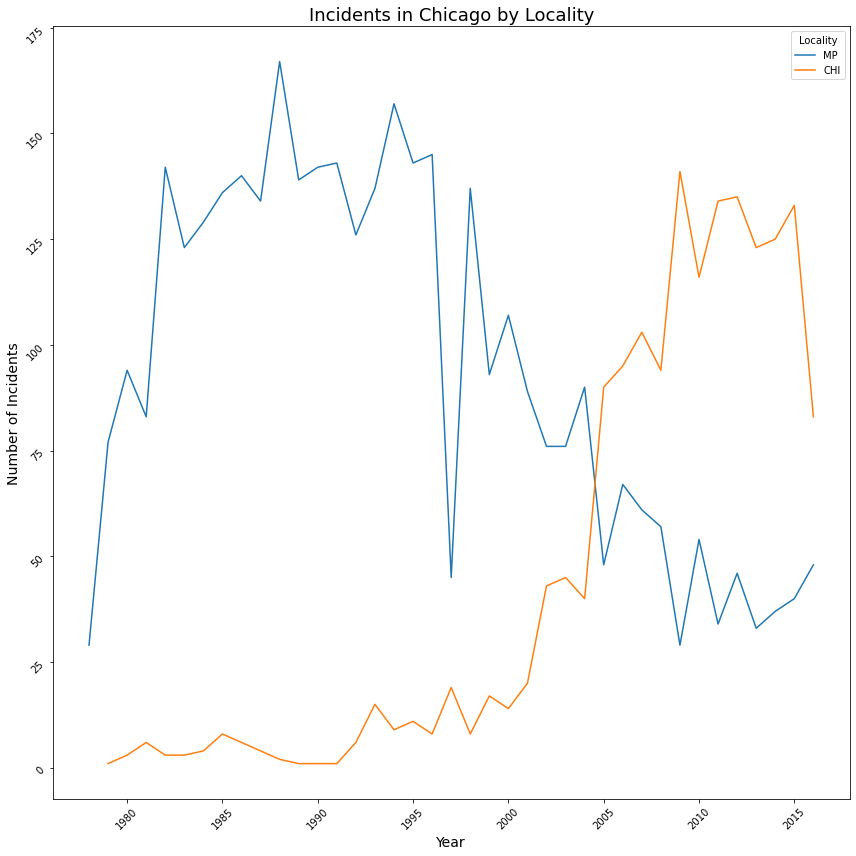

In [192]:
Chicago_Collisions_by_Locality
#Construct a line plot with the data
plt.rcParams["figure.figsize"] = [12,12]
plt.rcParams["figure.autolayout"] = True
ax = sns.lineplot(x="Incident_Year", y="Num", hue='Locality',data=Chicago_Collisions_by_Locality)
ax.tick_params(rotation=45)
ax.set_title('Incidents in Chicago by Locality',fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Incidents', fontsize=14)
plt.show()

<b> Insight(s):</b> The trend lines indicate that bird-building collisions in McCormick Place (MP) were high compared to the rest of Chicago (CHI) from 1978 to 2004.
<b> However </b>, around 2004, there was a sudden dip in the collisions in McCormick place. The average numbers dropped from 2004 onwards. This seems to be related to the construction of the bird sanctuary in McCormick Place. Read more about it here in the <a href = 
"https://www.mccormickplace.com/about/history/"> official website of McCormick Place. </a> However, bird-building collisions in the rest of Chicago continue to increase at an alarmingly high rate.

## Are light levels and collisions strongly correlated? 

This particular question requires us running <b> a query that combines all three containers namely Chicago_Collisions, Cleveland_Collisions and Light_levels. </b> GridDB supports standard sub-query functionality along with joins. Before we start building the query, it is important to note that the Light Score is stored as an string (varchar). We will use type casting available in GridDB to cast the string as an integer. GridDB supports all standard type casting functions available with most popular databases. Refer to the 'Cast' section <a href = "https://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_3_2/GridDB_AE_SQL_Reference.html#cast"> here </a> to know more about the different <b> type cast operations </b> supported in GridDB.  

In [301]:
sql_query6 = (f"""SELECT t1.Incident_Date, t2.Light_Score, Sum(cnt) as Number_of_Collisions FROM (SELECT STRFTIME('%m-%Y', Date) as Incident_Date, count(*) as cnt FROM Chicago_Collisions group by 1 UNION ALL SELECT STRFTIME('%m-%Y', Date) as Incident_Date, count(*) as cnt FROM Cleveland_Collisions group by 1 ) t1 INNER JOIN (SELECT STRFTIME('%m-%Y', Date) AS Incident_Date, AVG(CAST(Light_Score AS INTEGER)) AS Light_Score FROM Light_levels group by 1) t2 ON t1.Incident_Date = t2.Incident_Date GROUP BY 1,2""")
#sql_query6 = (f"""SELECT STRFTIME('%m-%d-%Y', Date) as Incident_Date, count(*) as cnt FROM Chicago_Collisions group by 1 UNION ALL SELECT STRFTIME('%m-%d-%Y', Date) as Incident_Date, count(*) as cnt FROM Cleveland_Collisions group by 1 """)
#sql_query6 = (f"""SELECT STRFTIME('%m-%d-%Y', Date) AS Incident_Date, AVG(CAST(Light_Score AS INTEGER)) AS Light_Score FROM Light_levels group by 1""")

In [302]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query6+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT t1.Incident_Date, t2.Light_Score, Sum(cnt) as Number_of_Collisions FROM (SELECT STRFTIME(\'%m-%Y\', Date) as Incident_Date, count(*) as cnt FROM Chicago_Collisions group by 1 UNION ALL SELECT STRFTIME(\'%m-%Y\', Date) as Incident_Date, count(*) as cnt FROM Cleveland_Collisions group by 1 ) t1 INNER JOIN (SELECT STRFTIME(\'%m-%Y\', Date) AS Incident_Date, AVG(CAST(Light_Score AS INTEGER)) AS Light_Score FROM Light_levels group by 1) t2 ON t1.Incident_Date = t2.Incident_Date GROUP BY 1,2"}]'

In [ ]:
#Invoke the GridDB WebAPI
data_req6 = requests.post(url, data=request_body, headers=header_obj)

In [304]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req6.json()
Collisions_and_Light_Levels = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])
Collisions_and_Light_Levels=Collisions_and_Light_Levels.sort_values(by=['Number_of_Collisions'], ascending=False)

In [305]:
Collisions_and_Light_Levels.sort_values('Number_of_Collisions', ascending=False)

Incident_Date  Light_Score  Number_of_Collisions
95        10-2010     9.714286                    31
111       10-2011    13.451613                    31
74        05-2006    10.740741                    31
72        10-2016    10.866667                    31
6         10-2012    13.870968                    31
..            ...          ...                   ...
38        03-2001     9.444444                     5
9         03-2002     3.300000                     5
21        08-2004    11.083333                     4
32        08-2002    16.555556                     2
27        08-2003     6.285714                     2

[123 rows x 3 columns]

C:\Users\mg_su\AppData\Local\Temp/ipykernel_18724/2485131425.py:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<AxesSubplot:>

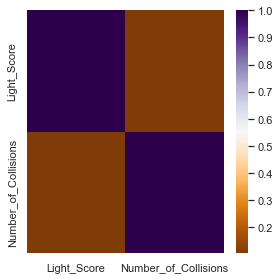

In [327]:

%matplotlib inline
plt.rcParams['figure.figsize']=4,4
    
# Calculate correlation between each pair of variable
corr_matrix=Collisions_and_Light_Levels.corr()
 
# plot it
sns.heatmap(corr_matrix, cmap='PuOr')  

<b> Insight(s): </b> Based on the limited data that we have, light_score and the number of collisions don't seem to have a strong correlation. However, we cannot say this with certainty as a lot of other studies show that there is a strong correlation between the light score and bird collisions. A lot more predictors like the weather, wind condition, etc. may be needed along with the light score.

Let's analyze the collisions and light levels are little more to see what we find.

## How many collisions occurred when the light score was the highest?

In [306]:
Collisions_and_Light_Levels.loc[(Collisions_and_Light_Levels['Light_Score']>=max(Collisions_and_Light_Levels['Light_Score']))]

Incident_Date  Light_Score  Number_of_Collisions
32       08-2002    16.555556                     2

<b> Insight: </b> There have been just 2 collisions when the light score has been the highest.

## How many collisions occurred when the light score was the lowest?

In [308]:
Collisions_and_Light_Levels.loc[(Collisions_and_Light_Levels['Light_Score']<=min(Collisions_and_Light_Levels['Light_Score']))]

Incident_Date  Light_Score  Number_of_Collisions
9       03-2002          3.3                     5

Insight: There have been 5 collisions when the light score was the lowest at 3.3.

# How many months had an average light score less than 10?

In [313]:
len(Collisions_and_Light_Levels.loc[(Collisions_and_Light_Levels['Light_Score']<=10)])

57

# Concluding Remarks

Bird-Building Collisions have led to an increased mass migration of birds. Based on several studies conducted over time, organizations like 'The Audubon Society' recommend turning the lights out after 11PM to save birds. Read more about it <a href = "https://blockclubchicago.org/2022/08/31/help-save-migrating-birds-by-turning-off-high-rise-lights-at-night-birders-say/" > here. </a> Using GRIDDB, we were able to effectively analyze time-series data and utilize both the TQL and SQL functionalities available in GRIDDB. Along with that, we also used the special time-series functions like TIME_NEXT AND TIME_PREVIOUS to get quick answers. Though the dataset is not as big, this is a good example to show how versatile GRIDDB can be for analyzing time-series data of any size.   